# Stock (Consumer Goods focused) portfolio creation, analysis, and risk measurements.

In this notebook we will calculate a number of well known financial statistics. The below statistics in question are usually calculated on a portfolio, so I will create an equallly weighted portfolio of sample stocks (although weights can be arbitrarily chosen). In order to provide examples on real data we will use the following stocks below to illustrate the concepts shown:

- 'CL' - Colgate-Palmolive Company 
- 'PG' - The Procter & Gamble Company
- 'JNJ' - Johnson & Johnson
- 'KMB' - Kimberly-Clark Corporation
- 'UL' - Unilever plc
- '^GSPC' - The ticker symbol for the S&P 500 index (broader market index)

*note*: ^GSPC is a price index, not a total return index, so it does not include dividends.


The statistics we will be calculating are the following:

- Sharpe ratio - https://www.investopedia.com/terms/s/sharperatio.asp
- Sortino Ratio - https://www.investopedia.com/terms/s/sortinoratio.asp
- Max Drawdown - https://www.investopedia.com/terms/m/maximum-drawdown-mdd.asp
- Calmar Ratio - https://corporatefinanceinstitute.com/resources/wealth-management/calmar-ratio/
- VaR - https://www.investopedia.com/terms/v/var.asp

<br>

**Time period of anaysis  =   01/01/2002 - 09/30/2022**

<br>

## Import modules

In [1]:
import time as t
import os
import glob
import math
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')

## Set path to cwd and read in stock files

In [2]:
# use glob to get all the csv files 
# in the folder
path = os.getcwd()
ticker_csv_files = glob.glob(os.path.join(path, "final_*.csv"))
print(ticker_csv_files)

['/Users/jarrodmautz/Documents/Python Projects/stock_proj/final_CL_df.csv', '/Users/jarrodmautz/Documents/Python Projects/stock_proj/final_^GSPC_df.csv', '/Users/jarrodmautz/Documents/Python Projects/stock_proj/final_PG_df.csv', '/Users/jarrodmautz/Documents/Python Projects/stock_proj/final_UL_df.csv', '/Users/jarrodmautz/Documents/Python Projects/stock_proj/final_JNJ_df.csv', '/Users/jarrodmautz/Documents/Python Projects/stock_proj/final_KMB_df.csv']


## Get list of stocks from list of files

In [3]:
# Create our portfolio of equities
stock_list = []
for f in ticker_csv_files:
    
    stock_list.append(f.split("l_")[-1].split('_')[0])

print(stock_list)

stock_df = dict(map(lambda i,j : (i,j), stock_list,ticker_csv_files))

['CL', '^GSPC', 'PG', 'UL', 'JNJ', 'KMB']


## Read in and display each stock's data

In [4]:
stocks = {}
# loop over the list of csv files
for i, f in stock_df.items():
    # read the csv file
    stocks[i] = pd.read_csv(f, parse_dates = ['date'])
    stocks[i].set_index('date', inplace=True)
    # print the location and filename
    print('Location:', f)
    print('File Name:', f.split("final_")[-1])
      
    # print the content
    print('Content:')
    display(stocks[i])
    print()

Location: /Users/jarrodmautz/Documents/Python Projects/stock_proj/final_CL_df.csv
File Name: CL_df.csv
Content:


,open,high,low,close,adjclose,volume,ticker,BB_UPPER,BB_MIDDLE,BB_LOWER,...,ema60,ema20,ema10,ema5,ema5Vol,realGDP_(qrt),consumerPriceIndex_(mo),consumerSentiment_(mo),retailSales_(mo),fedFundRate_(d)
date,,,,,,,,,,,,,,,,,,,,,
2002-01-02,28.625000,28.875000,28.325001,28.809999,18.210583,2360400,CL,NaN,NaN,NaN,...,1.000000,1.000000,1.000000,1.000000,1.000000,3263.869,177.100,93.0,230546,1.92
2002-01-03,28.684999,28.709999,28.434999,28.733076,18.147369,2003200,CL,NaN,NaN,NaN,...,0.998674,0.998696,0.998727,0.998785,0.925025,3263.869,177.100,93.0,230546,1.72
2002-01-04,28.584999,28.590000,27.815001,28.292015,17.774443,4467600,CL,NaN,NaN,NaN,...,0.988926,0.989120,0.989401,0.989933,1.452283,3263.869,177.100,93.0,230546,1.61
2002-01-07,27.875000,28.025000,27.700001,27.962435,17.587975,3746800,CL,NaN,NaN,NaN,...,0.983097,0.983515,0.984120,0.985251,1.138115,3263.869,177.100,93.0,230546,1.61
2002-01-08,27.950001,28.120001,27.875000,27.988795,17.698591,6180800,CL,NaN,NaN,NaN,...,0.987284,0.987823,0.988593,0.989993,1.508600,3263.869,177.100,93.0,230546,1.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,75.529999,75.779999,74.779999,75.135174,75.000000,3797200,CL,80.310186,77.060173,73.810161,...,0.957753,0.964448,0.976350,0.989175,0.916044,4985.795,296.808,58.2,575365,3.08
2022-09-27,75.360001,75.639999,72.529999,73.346554,72.580002,5260600,CL,80.159545,76.745752,73.331959,...,0.935951,0.944120,0.957188,0.971191,1.214607,4985.795,296.808,58.2,575365,3.08
2022-09-28,73.150002,73.410004,72.199997,73.040969,72.910004,6450900,CL,80.028152,76.438276,72.848400,...,0.933091,0.942872,0.957273,0.972470,1.377100,4985.795,296.808,58.2,575365,3.08



Location: /Users/jarrodmautz/Documents/Python Projects/stock_proj/final_^GSPC_df.csv
File Name: ^GSPC_df.csv
Content:


,open,high,low,close,adjclose,volume,ticker,BB_UPPER,BB_MIDDLE,BB_LOWER,...,ema60,ema20,ema10,ema5,ema5Vol,realGDP_(qrt),consumerPriceIndex_(mo),consumerSentiment_(mo),retailSales_(mo),fedFundRate_(d)
date,,,,,,,,,,,,,,,,,,,,,
2002-01-02,1148.079956,1154.670044,1136.229980,1154.670044,1154.670044,1171000000,^GSPC,NaN,NaN,NaN,...,1.000000,1.000000,1.000000,1.000000,1.000000,3263.869,177.100,93.0,230546,1.92
2002-01-03,1154.670044,1165.270020,1154.010010,1162.823871,1165.270020,1398900000,^GSPC,NaN,NaN,NaN,...,1.003489,1.003432,1.003350,1.003198,1.079974,3263.869,177.100,93.0,230546,1.72
2002-01-04,1165.270020,1176.550049,1163.420044,1169.792316,1172.510010,1513000000,^GSPC,NaN,NaN,NaN,...,1.006263,1.006122,1.005920,1.005546,1.095243,3263.869,177.100,93.0,230546,1.61
2002-01-07,1172.510010,1176.969971,1163.550049,1166.332682,1164.890015,1308300000,^GSPC,NaN,NaN,NaN,...,1.002442,1.002299,1.002099,1.001743,0.963482,3263.869,177.100,93.0,230546,1.61
2002-01-08,1164.890015,1167.599976,1157.459961,1162.387190,1160.709961,1258800000,^GSPC,NaN,NaN,NaN,...,0.999247,0.999149,0.999018,0.998812,0.946269,3263.869,177.100,93.0,230546,1.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,3682.719971,3715.669922,3644.760010,3673.819591,3655.040039,4886140000,^GSPC,4138.370017,3921.036224,3703.702431,...,0.901735,0.925049,0.938909,0.957343,1.072657,4985.795,296.808,58.2,575365,3.08
2022-09-27,3686.439941,3717.530029,3623.290039,3655.248905,3647.290039,4577740000,^GSPC,4139.991995,3901.304474,3662.616954,...,0.898691,0.923876,0.939788,0.960104,1.004124,4985.795,296.808,58.2,575365,3.08
2022-09-28,3651.939941,3736.739990,3640.610107,3699.902699,3719.040039,4684850000,^GSPC,4135.542813,3886.035754,3636.528695,...,0.911019,0.938058,0.955501,0.976416,1.022910,4985.795,296.808,58.2,575365,3.08



Location: /Users/jarrodmautz/Documents/Python Projects/stock_proj/final_PG_df.csv
File Name: PG_df.csv
Content:


,open,high,low,close,adjclose,volume,ticker,BB_UPPER,BB_MIDDLE,BB_LOWER,...,ema60,ema20,ema10,ema5,ema5Vol,realGDP_(qrt),consumerPriceIndex_(mo),consumerSentiment_(mo),retailSales_(mo),fedFundRate_(d)
date,,,,,,,,,,,,,,,,,,,,,
2002-01-02,39.450001,40.000000,39.009998,40.000000,22.805550,6261600,PG,NaN,NaN,NaN,...,1.000000,1.000000,1.000000,1.000000,1.000000,3263.869,177.100,93.0,230546,1.92
2002-01-03,39.654999,39.790001,39.305000,39.703847,22.586060,5216800,PG,NaN,NaN,NaN,...,0.996315,0.996375,0.996461,0.996621,0.916561,3263.869,177.100,93.0,230546,1.72
2002-01-04,39.619999,39.750000,39.099998,39.359352,22.363708,6181400,PG,NaN,NaN,NaN,...,0.991814,0.991986,0.992235,0.992697,1.050288,3263.869,177.100,93.0,230546,1.61
2002-01-07,39.115002,39.244999,38.549999,38.946966,22.107143,6412200,PG,NaN,NaN,NaN,...,0.986117,0.986470,0.986979,0.987926,1.058992,3263.869,177.100,93.0,230546,1.61
2002-01-08,38.775002,39.055000,38.639999,38.899976,22.167000,4009800,PG,NaN,NaN,NaN,...,0.988005,0.988480,0.989160,0.990395,0.731034,3263.869,177.100,93.0,230546,1.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,135.580002,136.820007,134.990005,135.730379,135.710007,7396400,PG,141.611196,138.162100,134.713004,...,0.936518,0.963840,0.977658,0.988496,1.142632,4985.795,296.808,58.2,575365,3.08
2022-09-27,135.960007,136.940002,131.710007,133.105111,131.979996,7722200,PG,141.312031,137.707730,134.103430,...,0.919634,0.947671,0.962357,0.974350,1.155792,4985.795,296.808,58.2,575365,3.08
2022-09-28,133.020004,133.020004,131.190002,132.317530,131.979996,10455100,PG,141.329318,137.284420,133.239522,...,0.915481,0.944670,0.960447,0.973682,1.430193,4985.795,296.808,58.2,575365,3.08



Location: /Users/jarrodmautz/Documents/Python Projects/stock_proj/final_UL_df.csv
File Name: UL_df.csv
Content:


,open,high,low,close,adjclose,volume,ticker,BB_UPPER,BB_MIDDLE,BB_LOWER,...,ema60,ema20,ema10,ema5,ema5Vol,realGDP_(qrt),consumerPriceIndex_(mo),consumerSentiment_(mo),retailSales_(mo),fedFundRate_(d)
date,,,,,,,,,,,,,,,,,,,,,
2002-01-02,18.611111,18.638889,18.333332,18.538889,9.031805,201420,UL,NaN,NaN,NaN,...,1.000000,1.000000,1.000000,1.000000,1.000000,3263.869,177.100,93.0,230546,1.92
2002-01-03,18.400000,18.422222,18.277779,18.414957,8.953313,96480,UL,NaN,NaN,NaN,...,0.996674,0.996728,0.996805,0.996950,0.669164,3263.869,177.100,93.0,230546,1.72
2002-01-04,18.194445,18.233334,18.000000,18.236332,8.850466,201780,UL,NaN,NaN,NaN,...,0.991371,0.991547,0.991800,0.992273,1.208504,3263.869,177.100,93.0,230546,1.61
2002-01-07,18.000000,18.027779,17.777779,18.049945,8.755732,210780,UL,NaN,NaN,NaN,...,0.985979,0.986337,0.986853,0.987813,1.164076,3263.869,177.100,93.0,230546,1.61
2002-01-08,17.938889,18.000000,17.833332,17.975915,8.742204,211320,UL,NaN,NaN,NaN,...,0.985614,0.986133,0.986875,0.988233,1.115147,3263.869,177.100,93.0,230546,1.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,44.189999,44.380001,43.490002,43.986132,43.820000,4909500,UL,46.573556,45.363705,44.153853,...,0.941682,0.956633,0.965800,0.974498,1.703576,4985.795,296.808,58.2,575365,3.08
2022-09-27,44.259998,44.459999,43.160000,43.512841,43.310001,5349800,UL,46.656270,45.236511,43.816752,...,0.932596,0.948764,0.959297,0.969829,1.624499,4985.795,296.808,58.2,575365,3.08
2022-09-28,43.310001,44.419998,43.130001,44.021853,44.240002,4552200,UL,46.633544,45.145503,43.657463,...,0.944380,0.961700,0.973127,0.984263,1.299502,4985.795,296.808,58.2,575365,3.08



Location: /Users/jarrodmautz/Documents/Python Projects/stock_proj/final_JNJ_df.csv
File Name: JNJ_df.csv
Content:


,open,high,low,close,adjclose,volume,ticker,BB_UPPER,BB_MIDDLE,BB_LOWER,...,ema60,ema20,ema10,ema5,ema5Vol,realGDP_(qrt),consumerPriceIndex_(mo),consumerSentiment_(mo),retailSales_(mo),fedFundRate_(d)
date,,,,,,,,,,,,,,,,,,,,,
2002-01-02,58.900002,59.299999,57.580002,58.700001,33.769238,7054600,JNJ,NaN,NaN,NaN,...,1.000000,1.000000,1.000000,1.000000,1.000000,3263.869,177.100,93.0,230546,1.92
2002-01-03,58.700001,58.730000,57.880001,58.684616,33.757725,6413100,JNJ,NaN,NaN,NaN,...,0.999870,0.999872,0.999875,0.999881,0.956509,3263.869,177.100,93.0,230546,1.72
2002-01-04,58.680000,58.900002,57.950001,58.292805,33.447083,4778400,JNJ,NaN,NaN,NaN,...,0.995490,0.995565,0.995675,0.995882,0.804087,3263.869,177.100,93.0,230546,1.61
2002-01-07,57.900002,58.500000,57.759998,57.994424,33.291744,4509300,JNJ,NaN,NaN,NaN,...,0.992838,0.993011,0.993262,0.993732,0.822679,3263.869,177.100,93.0,230546,1.61
2002-01-08,58.080002,58.099998,57.000000,57.640468,33.073124,4505900,JNJ,NaN,NaN,NaN,...,0.989482,0.989792,0.990240,0.991073,0.864946,3263.869,177.100,93.0,230546,1.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,165.800003,166.839996,164.380005,165.896313,165.699997,8735500,JNJ,167.327065,164.513172,161.699279,...,0.972329,0.992701,1.002025,1.003238,1.021641,4985.795,296.808,58.2,575365,3.08
2022-09-27,166.360001,167.669998,164.399994,165.226896,164.940002,8686700,JNJ,167.391399,164.594252,161.797104,...,0.968907,0.989227,0.998164,0.999325,1.013243,4985.795,296.808,58.2,575365,3.08
2022-09-28,166.250000,167.380005,165.100006,166.020069,166.360001,8660900,JNJ,167.485726,164.756126,162.026525,...,0.973981,0.994261,1.002687,1.003433,1.008513,4985.795,296.808,58.2,575365,3.08



Location: /Users/jarrodmautz/Documents/Python Projects/stock_proj/final_KMB_df.csv
File Name: KMB_df.csv
Content:


,open,high,low,close,adjclose,volume,ticker,BB_UPPER,BB_MIDDLE,BB_LOWER,...,ema60,ema20,ema10,ema5,ema5Vol,realGDP_(qrt),consumerPriceIndex_(mo),consumerSentiment_(mo),retailSales_(mo),fedFundRate_(d)
date,,,,,,,,,,,,,,,,,,,,,
2002-01-02,57.094917,57.094917,56.538830,56.903164,28.373573,1059062,KMB,NaN,NaN,NaN,...,1.000000,1.000000,1.000000,1.000000,1.000000,3263.869,177.100,93.0,230546,1.92
2002-01-03,56.663471,56.663471,56.232021,56.571282,28.158440,1465937,KMB,NaN,NaN,NaN,...,0.997099,0.997146,0.997214,0.997340,1.144375,3263.869,177.100,93.0,230546,1.72
2002-01-04,56.471718,56.500481,55.407478,55.920250,27.756865,1566795,KMB,NaN,NaN,NaN,...,0.990449,0.990635,0.990904,0.991408,1.123909,3263.869,177.100,93.0,230546,1.61
2002-01-07,56.136147,56.136147,54.745926,55.463652,27.560846,2269255,KMB,NaN,NaN,NaN,...,0.986822,0.987174,0.987682,0.988623,1.354140,3263.869,177.100,93.0,230546,1.61
2002-01-08,55.321190,55.455418,54.697987,55.087847,27.388746,1789162,KMB,NaN,NaN,NaN,...,0.984176,0.984712,0.985482,0.986895,1.047898,3263.869,177.100,93.0,230546,1.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,120.480003,120.769997,118.029999,119.280492,118.779999,1854600,KMB,131.126507,124.604825,118.083144,...,0.913808,0.934885,0.956528,0.975835,1.263295,4985.795,296.808,58.2,575365,3.08
2022-09-27,119.169998,120.070000,117.080002,117.817149,117.190002,2040300,KMB,130.694149,124.000848,117.307546,...,0.904041,0.926796,0.949559,0.969704,1.305009,4985.795,296.808,58.2,575365,3.08
2022-09-28,118.120003,118.120003,116.680000,117.371145,117.180000,2026000,KMB,130.268378,123.411904,116.555431,...,0.902089,0.926673,0.950634,0.971533,1.234966,4985.795,296.808,58.2,575365,3.08


# Create our portfolio of stocks

In [5]:
# Set the investment weights (I arbitrarily picked for example)
weights = np.array([1/len(stock_list) for i in range(len(stock_list))]) #1/6th for each
print(weights)
# Set an initial investment level of $100,000
initial_investment = 100000

[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]


## Analyzing Daily returns


Stock levels (prices) tend to follow a pattern of cycles rather than seasonality. This along with numerous other factors tend to make stock levels random and therefore stochastic. Some think stocks follow a path of geometric brownian motion. That assumption along with advancements within Stochastic differential equations allowed for the derivation of black scholes formula, which is frequently used in modern options theory pricing. 

After plotting returns over the 20 year period for our stocks intuition says it may be a better idea to forecast direction of returns rather than stock prices since returns seem much more stationary.

Enough talk, lets continue analyzing our returns.

To create the financial statistics we seek we will need to first access the returns for our portfolio over time. This is simply the percent change from one time period to the next. The days in the index of our data correspond to business days only which is very nice to have for later backtesting strategies and portfolio allocations. We additionally will drop all empty values at the beginning.



###  Pull daily returns from adjclose prices in our data for each stock

In [6]:
daily_returns = {}
for i in stock_list:
    daily_returns[i] = stocks[i]['adjclose'].pct_change().dropna()
    daily_returns[i].rename('daily_return', inplace=True)

### Plot our daily returns for each stock

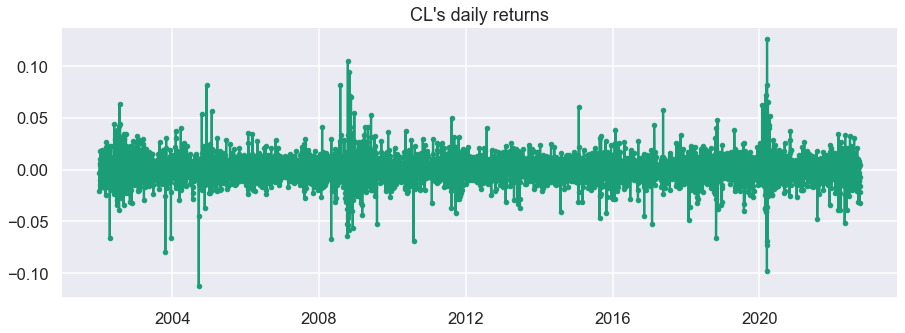

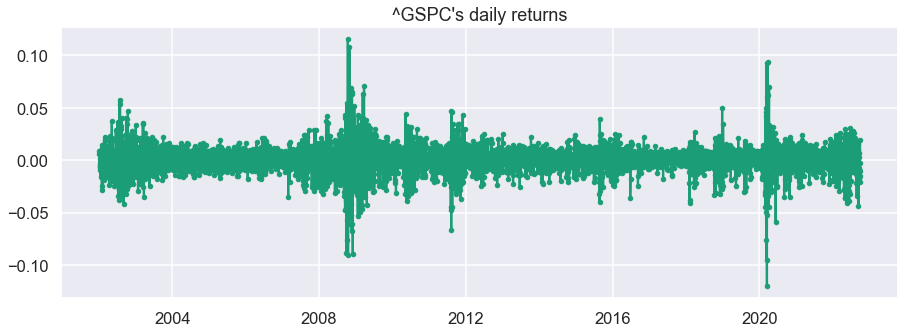

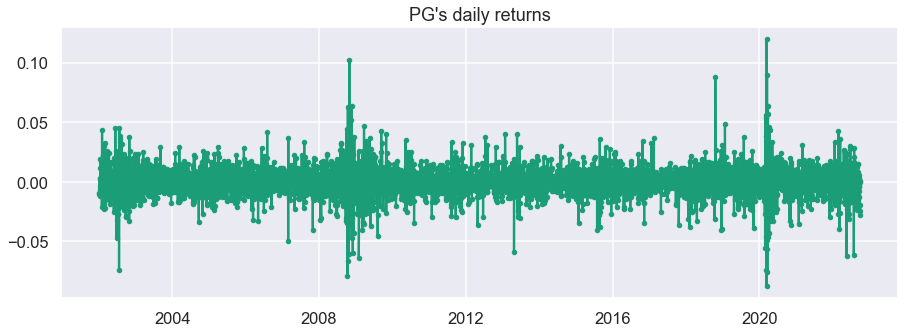

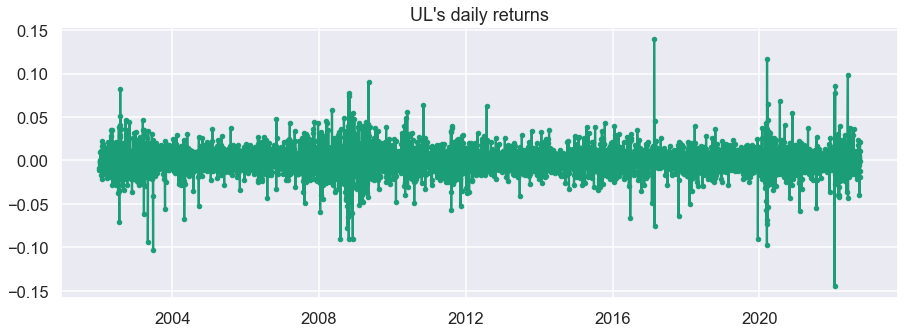

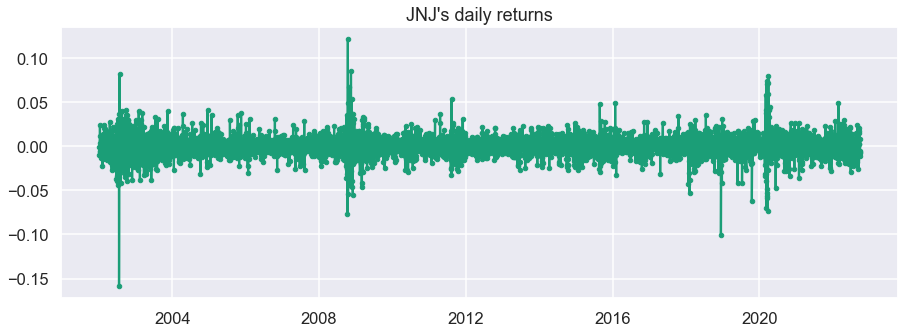

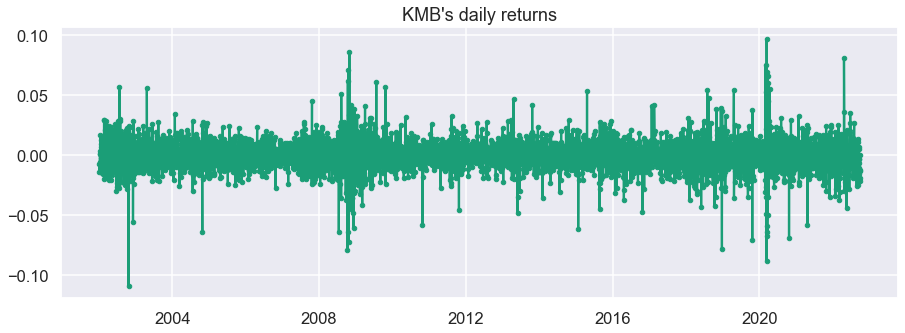

In [7]:
for i in stock_list:    
    plt.figure(figsize=(15,5))
    plt.title("{}'s daily returns".format(i))
    plt.plot(daily_returns[i], marker='.')

### How are our returns distributed for each stock?

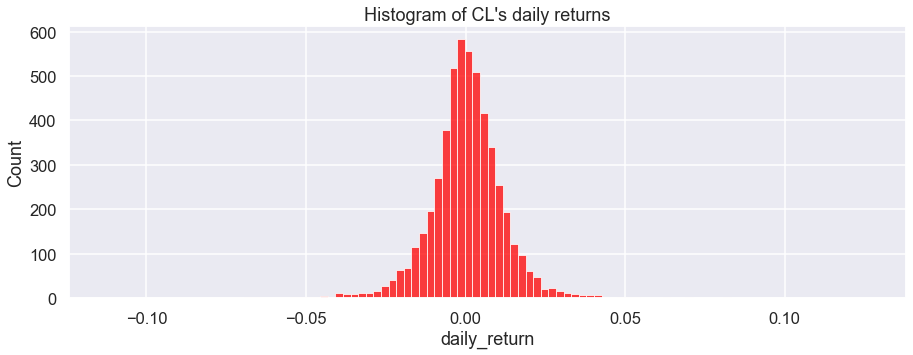

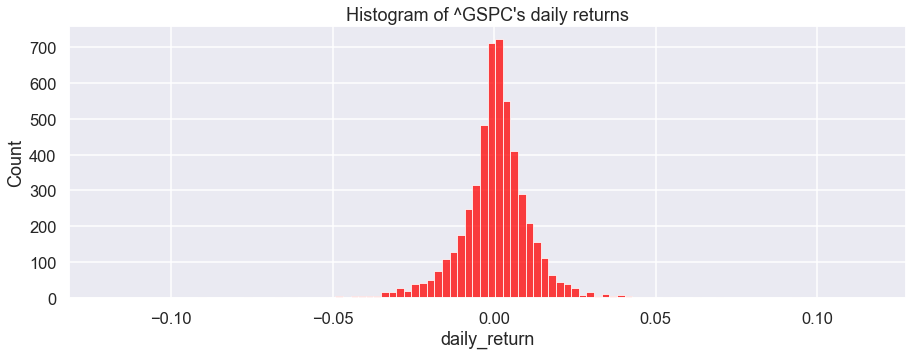

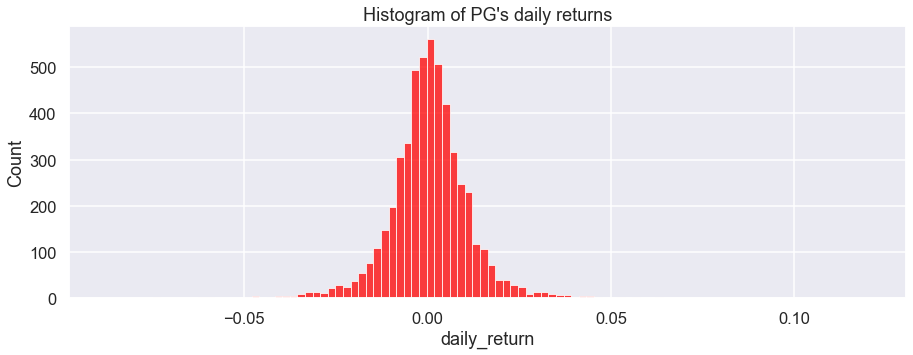

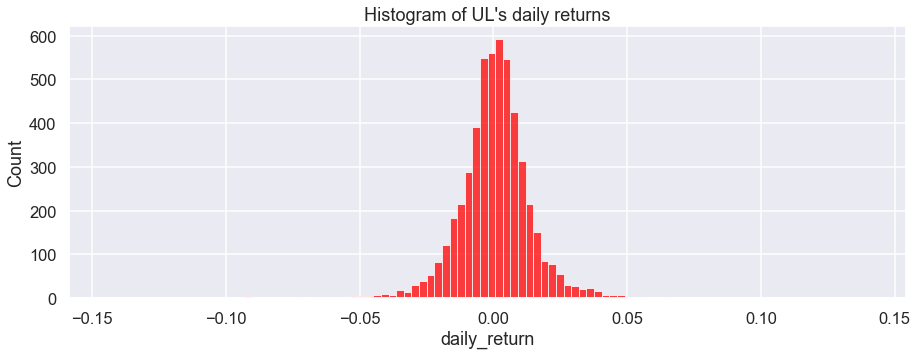

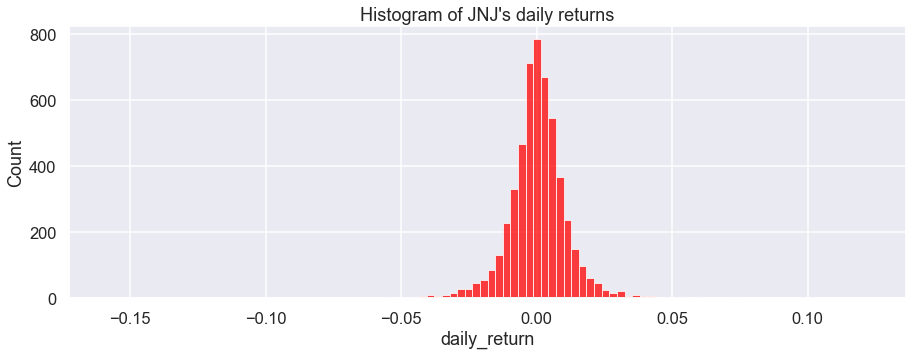

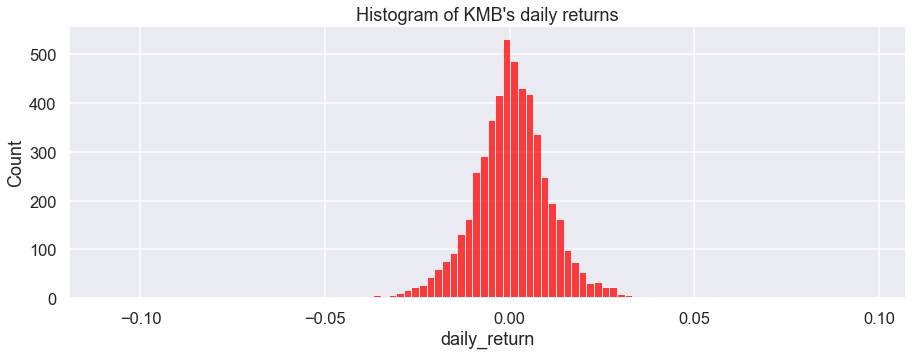

In [8]:
for i in stock_list:
    plt.figure(figsize=(15,5))
    plt.title("Histogram of {}'s daily returns".format(i))
    sns.histplot(x=daily_returns[i],bins=100,color='red')



Based on our data, our stocks daily returns look fairly normally distributed. 

Stock levels (prices) are usually log normally distributed, and stock price returns are usually normally distributed. 

<br>


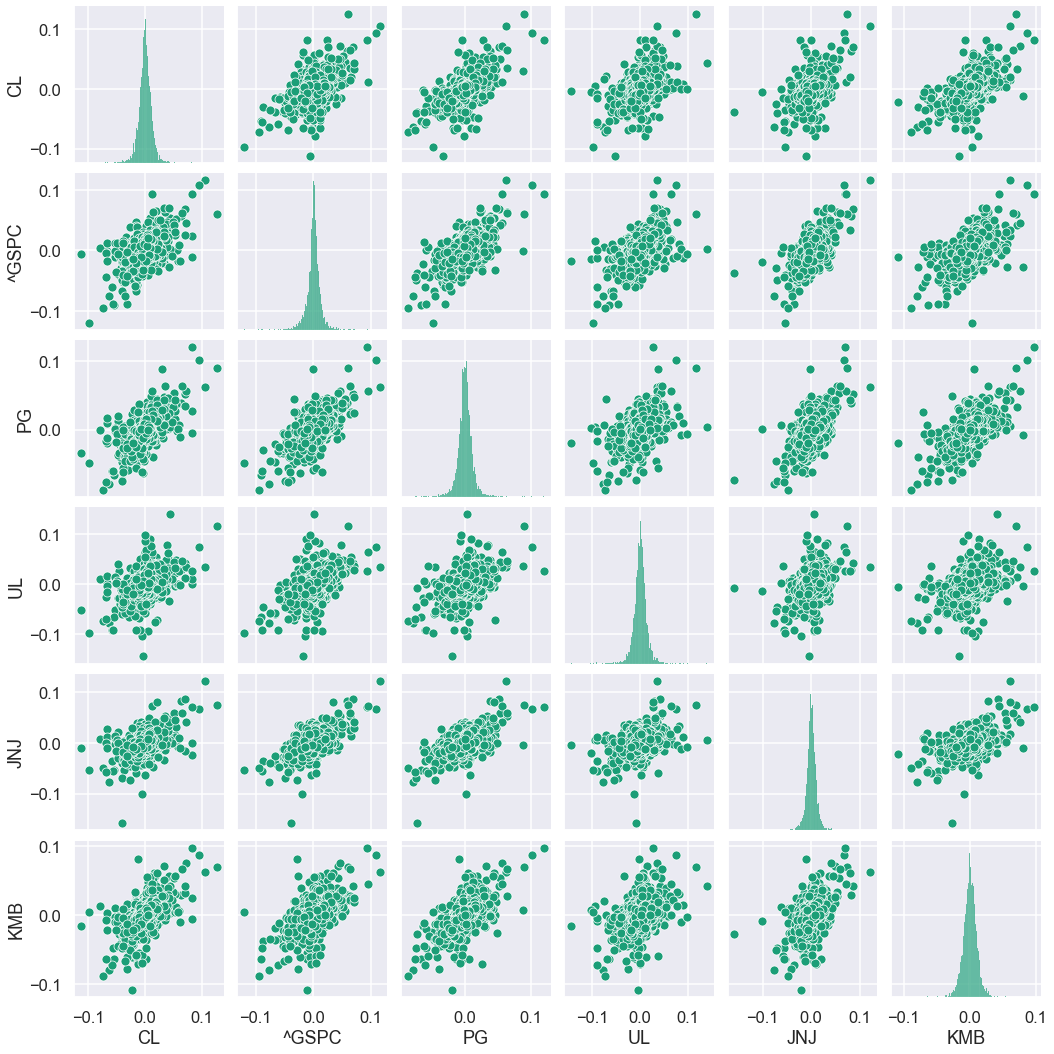

In [9]:
daily_rets = pd.DataFrame(daily_returns)
sns.pairplot(daily_rets)

<AxesSubplot:>

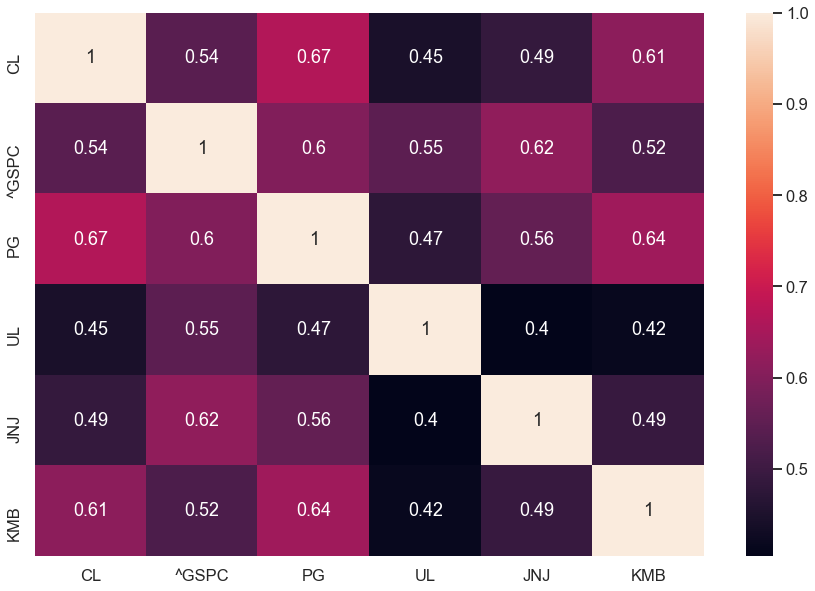

In [10]:
plt.figure(figsize=(15,10))
sns.heatmap(daily_rets.corr(), annot=True)

<br>

## Create daily weighted portfolio allocations

After getting our daily returns for each stock we now need to create our daily allocations for each stock by adjusting our weights to our returns for each day. 

First, we create a for loop and zip our stocks to their respective weights. Then we multiply our weights to each stock's series of normalized returns, which is simply dividing each close price by the last close price in the data.

In [11]:
allocations = {}
for i, weights in zip(stock_list, weights):
    allocations[i] = (stocks[i]['adjclose']/ stocks[i].iloc[0]['adjclose']) * weights
    allocations[i].rename('allocations', inplace=True)
#display(allocations)

<br>

## Create daily portfolio positions based on initial investment and allocations for each stock

The next step in creating our portfolio is to create our daily positions for each stock in our portfolio. This will be based on our daily allocations allong with our initial investment. For example, let’s assume our portfolio size is 10k on the first day. We simply multiply it with the Allocation column for each company which is already adjusted to the normalized return. 

This will give us the amount of money invested in each stock in our portfolio over time. We will afterwards utilize the position column for each stock to get our total portfolio position over time.


In [12]:
positions = {}
for i in stock_list:
    positions[i] = allocations[i] * initial_investment
    positions[i].rename('positions', inplace=True)
#display(positions)

## Combine portfolio info for each stock into one dataframe

In [13]:
portfolio = {}
for i in stock_list:
    portfolio[i] = pd.concat([daily_returns[i], allocations[i], positions[i]], axis=1)
    print('Portfolio information for: ' + i)
    display(portfolio[i])

Portfolio information for: CL


,daily_return,allocations,positions
date,,,
2002-01-02,NaN,0.166667,16666.666667
2002-01-03,-0.003471,0.166088,16608.812625
2002-01-04,-0.020550,0.162675,16267.503108
2002-01-07,-0.010491,0.160968,16096.843985
2002-01-08,0.006289,0.161981,16198.082448
...,...,...,...
2022-09-26,-0.007017,0.686414,68641.405842
2022-09-27,-0.032267,0.664266,66426.578156
2022-09-28,0.004547,0.667286,66728.602017


Portfolio information for: ^GSPC


,daily_return,allocations,positions
date,,,
2002-01-02,NaN,0.166667,16666.666667
2002-01-03,0.009180,0.168197,16819.668176
2002-01-04,0.006213,0.169242,16924.171194
2002-01-07,-0.006499,0.168142,16814.183133
2002-01-08,-0.003588,0.167538,16753.847662
...,...,...,...
2022-09-26,-0.010341,0.527574,52757.352028
2022-09-27,-0.002120,0.526455,52645.487459
2022-09-28,0.019672,0.536811,53681.136855


Portfolio information for: PG


,daily_return,allocations,positions
date,,,
2002-01-02,NaN,0.166667,16666.666667
2002-01-03,-0.009624,0.165063,16506.259767
2002-01-04,-0.009845,0.163438,16343.761984
2002-01-07,-0.011472,0.161563,16156.260040
2002-01-08,0.002708,0.162000,16200.004081
...,...,...,...
2022-09-26,0.000959,0.991791,99179.080652
2022-09-27,-0.027485,0.964531,96453.127943
2022-09-28,0.000000,0.964531,96453.127943


Portfolio information for: UL


,daily_return,allocations,positions
date,,,
2002-01-02,NaN,0.166667,16666.666667
2002-01-03,-0.008691,0.165218,16521.822669
2002-01-04,-0.011487,0.163320,16332.035765
2002-01-07,-0.010704,0.161572,16157.219857
2002-01-08,-0.001545,0.161323,16132.256463
...,...,...,...
2022-09-26,-0.000684,0.808624,80862.388541
2022-09-27,-0.011638,0.799213,79921.273007
2022-09-28,0.021473,0.816374,81637.431075


Portfolio information for: JNJ


,daily_return,allocations,positions
date,,,
2002-01-02,NaN,0.166667,16666.666667
2002-01-03,-0.000341,0.166610,16660.984594
2002-01-04,-0.009202,0.165077,16507.668407
2002-01-07,-0.004644,0.164310,16431.001842
2002-01-08,-0.006567,0.163231,16323.102703
...,...,...,...
2022-09-26,-0.006118,0.817805,81780.544032
2022-09-27,-0.004587,0.814055,81405.451906
2022-09-28,0.008609,0.821063,82106.286094


Portfolio information for: KMB


,daily_return,allocations,positions
date,,,
2002-01-02,NaN,0.166667,16666.666667
2002-01-03,-0.007582,0.165403,16540.296925
2002-01-04,-0.014261,0.163044,16304.411298
2002-01-07,-0.007062,0.161893,16189.269991
2002-01-08,-0.006244,0.160882,16088.178231
...,...,...,...
2022-09-26,-0.012553,0.697715,69771.495651
2022-09-27,-0.013386,0.688375,68837.530137
2022-09-28,-0.000085,0.688317,68831.654872


## Combine all portfolio positions into one DF and create a Total Portfolio Position column

In [14]:
all_pos = [portfolio[i]['positions'] for i in stock_list]
portf_val = pd.concat(all_pos, axis=1)
portf_val.columns = [i + ' Position' for i in stock_list]
portf_val['Total Portfolio Position'] = portf_val.sum(axis=1)
display(portf_val)

,CL Position,^GSPC Position,PG Position,UL Position,JNJ Position,KMB Position,Total Portfolio Position
date,,,,,,,
2002-01-02,16666.666667,16666.666667,16666.666667,16666.666667,16666.666667,16666.666667,100000.000000
2002-01-03,16608.812625,16819.668176,16506.259767,16521.822669,16660.984594,16540.296925,99657.844757
2002-01-04,16267.503108,16924.171194,16343.761984,16332.035765,16507.668407,16304.411298,98679.551756
2002-01-07,16096.843985,16814.183133,16156.260040,16157.219857,16431.001842,16189.269991,97844.778848
2002-01-08,16198.082448,16753.847662,16200.004081,16132.256463,16323.102703,16088.178231,97695.471588
...,...,...,...,...,...,...,...
2022-09-26,68641.405842,52757.352028,99179.080652,80862.388541,81780.544032,69771.495651,452992.266746
2022-09-27,66426.578156,52645.487459,96453.127943,79921.273007,81405.451906,68837.530137,445689.448607
2022-09-28,66728.602017,53681.136855,96453.127943,81637.431075,82106.286094,68831.654872,449438.238855


## Plot each investment's positions within our portfolio over time

In [1]:
portf_val.drop('Total Portfolio Position', axis=1).plot(figsize=(15,10))
plt.title("Each stock's portfolio positions over time")
plt.ylabel('Total Portfolio Worth ($)')

NameError: name 'portf_val' is not defined

## Plot our Total Portfolio Position over time

Text(0, 0.5, 'Total Portfolio Worth')

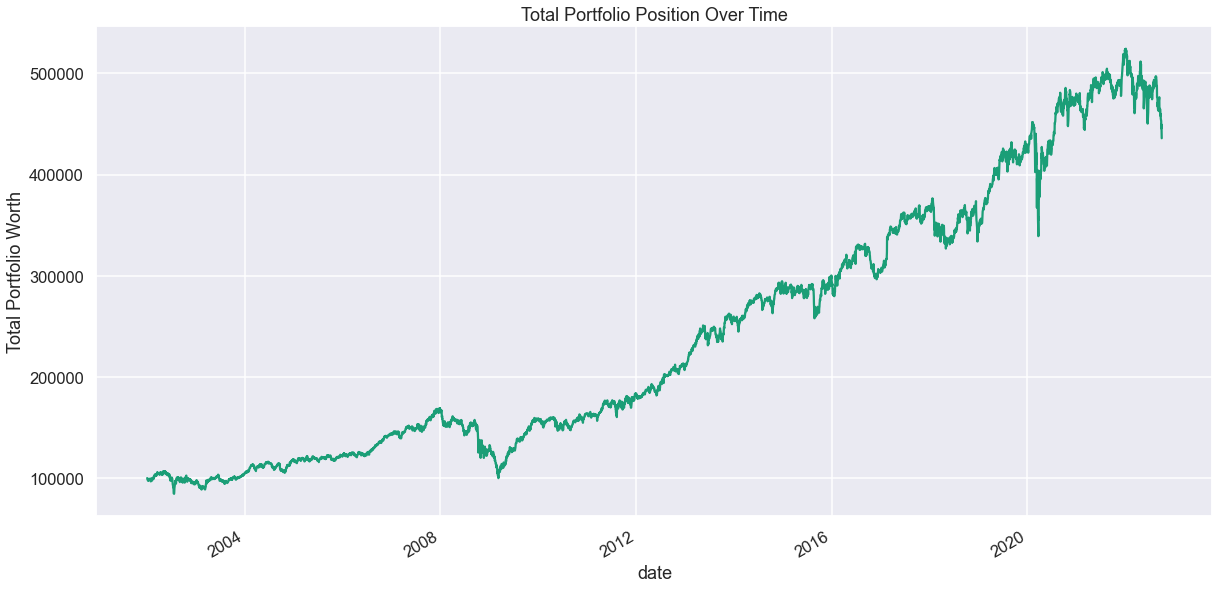

In [16]:
portf_val['Total Portfolio Position'].plot(figsize=(20,10))
plt.title('Total Portfolio Position Over Time')
plt.ylabel('Total Portfolio Worth')

As to be expected we can see our portfolio too large hits following the financial crisis of 2008 and in 2020 during the pandemic. Nonetheless our portfolio has perfomed pretty well on the surface over the years. We will be able to get a better picture of risk adjusted returns shortly after we calculate our statistics below.

<br>

## What was our portfolios cumulative return?

What is really important to us as investors is return on investment over time. We can think of this as our cumulative return for our total portfolio.

Investors commonly assess this calculation at the total portfolio level to get a wholistic view of portfolio performance over time.

In [17]:
cumulative_return = (portf_val['Total Portfolio Position'][-1]/portf_val['Total Portfolio Position'][0] -1) * 100

print('Your cumulative return was {:.2f}% '.format(cumulative_return))

Your cumulative return was 335.95% 


<br>

## Bonus: If I invested a dollar into any investment within the portfolio or the portfolio itself on 01/01/2002,  how would each perform?


Before we can calculate our statistics we first will need to create a Total Portfolio Return column within the daily_rets dataframe above to capture the daily returns of our total portfolio.

Recall the daily_rets dataframe below:

In [18]:
daily_rets

,CL,^GSPC,PG,UL,JNJ,KMB
date,,,,,,
2002-01-03,-0.003471,0.009180,-0.009624,-0.008691,-0.000341,-0.007582
2002-01-04,-0.020550,0.006213,-0.009845,-0.011487,-0.009202,-0.014261
2002-01-07,-0.010491,-0.006499,-0.011472,-0.010704,-0.004644,-0.007062
2002-01-08,0.006289,-0.003588,0.002708,-0.001545,-0.006567,-0.006244
2002-01-09,0.004464,-0.004799,-0.007201,0.000309,-0.010088,0.000872
...,...,...,...,...,...,...
2022-09-26,-0.007017,-0.010341,0.000959,-0.000684,-0.006118,-0.012553
2022-09-27,-0.032267,-0.002120,-0.027485,-0.011638,-0.004587,-0.013386
2022-09-28,0.004547,0.019672,0.000000,0.021473,0.008609,-0.000085


In [19]:
daily_rets.columns = [i + ' daily return' for i in stock_list]
daily_rets['Total Portfolio Return'] = daily_rets.mean(axis=1)
display(daily_rets)

,CL daily return,^GSPC daily return,PG daily return,UL daily return,JNJ daily return,KMB daily return,Total Portfolio Return
date,,,,,,,
2002-01-03,-0.003471,0.009180,-0.009624,-0.008691,-0.000341,-0.007582,-0.003422
2002-01-04,-0.020550,0.006213,-0.009845,-0.011487,-0.009202,-0.014261,-0.009855
2002-01-07,-0.010491,-0.006499,-0.011472,-0.010704,-0.004644,-0.007062,-0.008479
2002-01-08,0.006289,-0.003588,0.002708,-0.001545,-0.006567,-0.006244,-0.001491
2002-01-09,0.004464,-0.004799,-0.007201,0.000309,-0.010088,0.000872,-0.002740
...,...,...,...,...,...,...,...
2022-09-26,-0.007017,-0.010341,0.000959,-0.000684,-0.006118,-0.012553,-0.005959
2022-09-27,-0.032267,-0.002120,-0.027485,-0.011638,-0.004587,-0.013386,-0.015247
2022-09-28,0.004547,0.019672,0.000000,0.021473,0.008609,-0.000085,0.009036


Perhaps another cool way to look at our portfolio over time is to look at the growth one dollar invested at the start of our analysis till then end. In other words, to observe how one dollar invested in each ticker from 01/01/2002 - 09/30/2022 performed.

had we not dropped the first row of na values earlier when reading in returns, 

,CL $,^GSPC $,PG $,UL $,JNJ $,KMB $,Total Portfolio $
date,,,,,,,
2002-01-03,0.996529,1.009180,0.990376,0.991309,0.999659,0.992418,0.996578
2002-01-04,0.976050,1.015450,0.980626,0.979922,0.990460,0.978265,0.986757
2002-01-07,0.965811,1.008851,0.969376,0.969433,0.985860,0.971356,0.978390
2002-01-08,0.971885,1.005231,0.972000,0.967935,0.979386,0.965291,0.976931
2002-01-09,0.976224,1.000407,0.965001,0.968235,0.969506,0.966133,0.974254
...,...,...,...,...,...,...,...
2022-09-26,4.118484,3.165441,5.950745,4.851743,4.906833,4.186290,5.213975
2022-09-27,3.985595,3.158729,5.787188,4.795276,4.884327,4.130252,5.134476
2022-09-28,4.003716,3.220868,5.787188,4.898246,4.926377,4.129899,5.180871


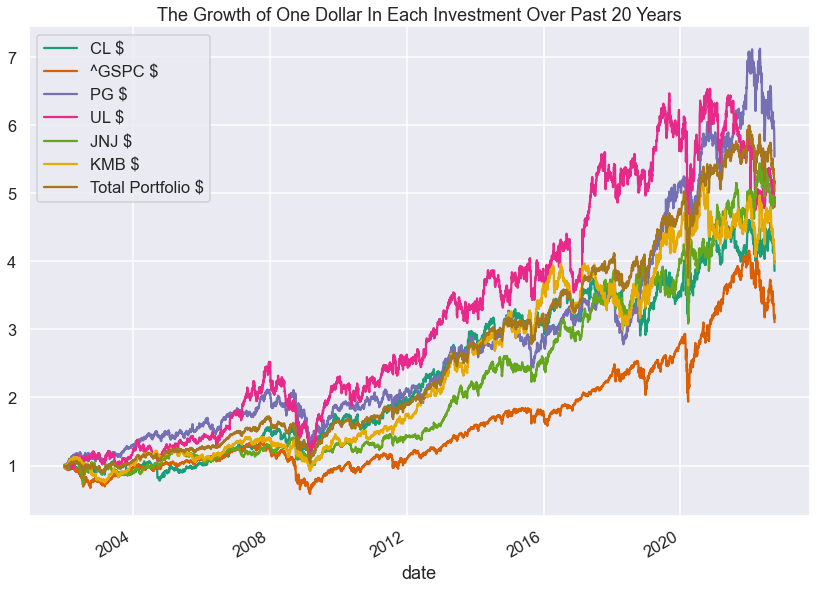

In [20]:
all_cols = stock_list + ['Total Portfolio']
dol_growth = (daily_rets+1).cumprod()
dol_growth.columns = [i + ' $' for i in all_cols]
dol_growth.plot(figsize=(14,10))
plt.title("The Growth of One Dollar In Each Investment Over Past 20 Years")

display(dol_growth)

<br>

# Now that we have a real portfolio simulated over the past 20 years, lets finally calculate our financial statistics. 

**Note**: Since our data frequency is daily we need to annualize both the expected return and standard deviation. This can be achieved by multiplying the daily average return by 255, and multiplying the daily standard deviation by √255. For simplicity we will assume that the risk-free rate rfr = average daily rfr% throughout the 20 year period since we have access to daily fed fund interest rate in our data already. This column is the same in each stock csv file we used so we can use any stocks 'fedFundRate_(d)' column

In [21]:
average_rfr = ((stocks[i]['fedFundRate_(d)']/100).mean()) #% risk free rate

## Sharpe Ratio
 

The Sharpe ratio is the most common ratio for comparing reward (return on investment) to risk (standard deviation). This allows us to adjust the returns on an investment by the amount of risk that was taken in order to achieve it. The Sharpe ratio also provides a useful metric to compare investments. The calculations are as follows:

Sharpe ratio =  (R − rfr) / σ


R:  annual expected return of the asset in question. 

rfr: annual risk-free rate. Think of this like a deposit in the bank earning x% per annum.  

σ :  annualized standard deviation of returns


You can interpret the Sharpe ratio as - higher numbers relate to better risk-adjusted investments.


CL                 0.366087
^GSPC              0.314025
PG                 0.475601
UL                 0.394220
JNJ                0.440341
KMB                0.380586
Total Portfolio    0.504633
dtype: float64

Text(0, 0.5, 'Sharpe Ratio')

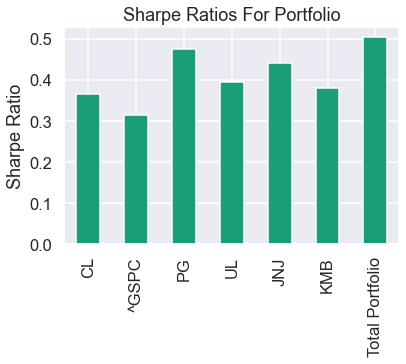

In [22]:
def sharpe_ratio(series, N, rfr):
    nomin = series.mean() * N -rfr
    sigma = series.std() * np.sqrt(N)
    return nomin / sigma

N = 255 #255 trading days in a year

sharpe = daily_rets.copy()
sharpe.columns = [i for i in all_cols]


sharpes = sharpe.apply(sharpe_ratio, args=(N,average_rfr,),axis=0)
display(sharpes)
sharpes.plot.bar()
plt.title('Sharpe Ratios For Portfolio')
plt.ylabel('Sharpe Ratio')

## Sortino Ratio

The Sortino ratio is similar to the Sharpe ratio, the main difference being that where the Sharpe ratio uses all the observations for calculating the standard deviation, the Sortino ratio only considers the downside variance. So in the plot below, we are only considering the deviations to the left of the mean. 

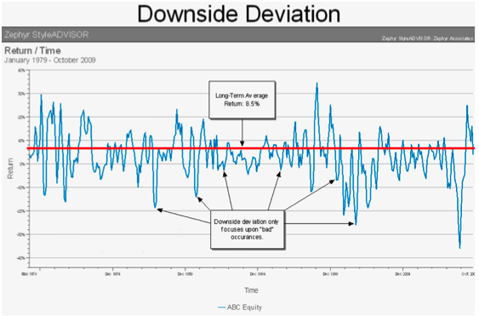


The intuition behind the ratio is that investors aren't worried about positive deviations (upward price movements), however the negative deviations are of major concern, since they represent a loss. 

Sortino ratio = (R − rfr) / σ-

R:  annual expected return of the asset in question. 

rfr: annual risk-free rate. Think of this like a deposit in the bank earning x% per annum.  
 
σ- = the annualized down-side standard deviation. 

Everything in the ratio above is the same as the Sharpe ratio except σ-.

Text(0, 0.5, 'Sortino Ratio')

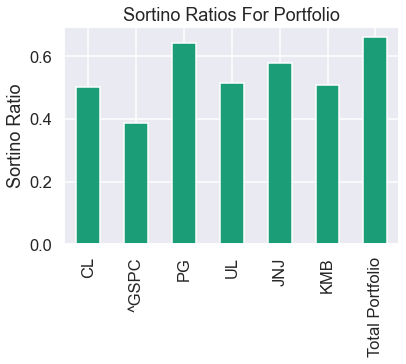

In [23]:
def sortino_ratio(series, N, rfr):
    mean = series.mean() * N - rfr
    std_neg = series[series<0].std() * np.sqrt(N)
    return mean/std_neg


sortino = daily_rets.copy()
sortino.columns = [i for i in all_cols]


sortinos = sortino.apply(sortino_ratio, args=(N,average_rfr,), axis=0)
sortinos.plot.bar()
plt.title('Sortino Ratios For Portfolio')
plt.ylabel('Sortino Ratio')


## Max Drawdown

Max drawdown quantifies the steepest decline from peak to trough observed for an investment.
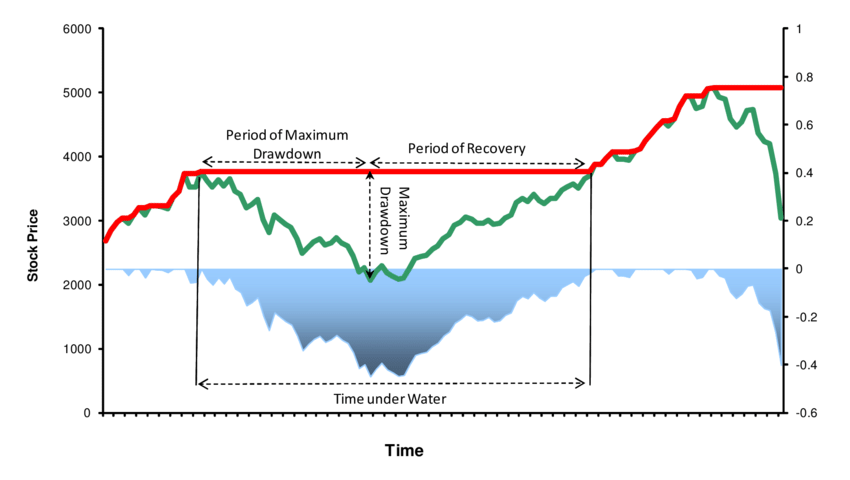


To calculate max drawdown first we need to calculate a series of drawdowns as follows:

drawdowns = (peak - trough) / peak

We then take the absolute of the minimum of this value throughout the period of analysis. In our case ~20 years. 

You can interpret max drawdown as - numbers closer to zero are most preferable.


Text(0, 0.5, 'Investment Max Drawdown')

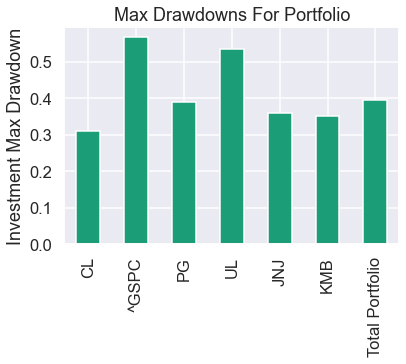

In [24]:
def max_drawdown(return_series):
    comp_ret = (return_series+1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return np.absolute(dd.min())


max_dd = daily_rets.copy()
max_dd.columns = [i for i in all_cols]



max_drawdowns = max_dd.apply(max_drawdown,axis=0)
max_drawdowns.plot.bar()
plt.title('Max Drawdowns For Portfolio')
plt.ylabel('Investment Max Drawdown')

## Calmar Ratio

The Calmar ratio is similar to the other ratios, with the key difference being that it uses max drawdown in the denominator as opposed to standard deviation. 

Calmar ratio = R / max drawdown

R:  annual expected return of the asset in question.

You can interpret the Calmar ratio as - along with the Sharpe and Sortino ratios, higher values are preferable.

Text(0, 0.5, 'Calmar Ratio')

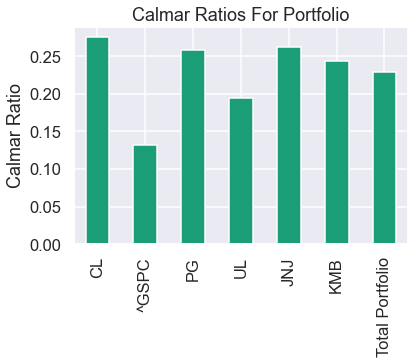

In [25]:
calmar = daily_rets.copy()

calmar.columns = [i for i in all_cols]

calmars_ratio = calmar.mean()*255/abs(max_drawdowns)

calmars_ratio.plot.bar()
plt.title('Calmar Ratios For Portfolio')
plt.ylabel('Calmar Ratio')

## Now lets display the ratios for our portfolio all at once. 

Given our analysis period was the past 20 years. 

In [26]:
stats = pd.DataFrame()
stats['sortino'] = sortinos
stats['sharpe'] = sharpes
stats['maxdd'] = max_drawdowns
stats['calmar'] = calmars_ratio

stats

,sortino,sharpe,maxdd,calmar
CL,0.502336,0.366087,0.310906,0.275432
^GSPC,0.388389,0.314025,0.567754,0.131695
PG,0.641022,0.475601,0.390101,0.257667
UL,0.516294,0.394220,0.535411,0.193845
JNJ,0.580122,0.440341,0.358800,0.261870
KMB,0.507931,0.380586,0.350835,0.243721
Total Portfolio,0.661333,0.504633,0.396322,0.228842


## Bonus: Plot expected returns vs risk of returns for portfolio

In [2]:
annual_expected_return = daily_rets.mean() *255

plt.figure(figsize=(14,7))
plt.title("Analyzing Risk: Expected Returns vs Std of Returns")
plt.scatter(annual_expected_return, daily_rets.std())
plt.xlabel('Expected Return')
plt.ylabel('Std of Returns (Risk)')

for idx, stock in enumerate(all_cols):
    plt.annotate(stock, (annual_expected_return[idx], daily_rets.std()[idx]))

NameError: name 'daily_rets' is not defined

We can interpret the above as - higher expected returns and lower std is better. Therefore our portfolio does decent with low risk for average reward but PG also has higher reward and average risk relative to our other investments.

The above statistics we calculated give us insight into how our portfolio performed adjusted for risk across our analysis period. Although these may be some of the more famous financial statisitcs there are other metrics such as VaR which help us measure risk for our portfolio as well. One of which is VaR which can also help us get a future assessment of our capital at risk. 

<br>

## Value at Risk (VaR)

Value at risk (VaR) is a statistic that quantifies the extent of possible financial losses within a firm, portfolio, or position over a specific time frame. This metric is most commonly used by investment and commercial banks to determine the extent and probabilities of potential losses in their institutional portfolios.

In other words, VaR can be thought of as the amount of money we could expect to lose for a given confidence interval over a specified period of time. 

Before we start, note that the standard VaR calculation assumes the following:

- Normal distribution of returns - VaR assumes the returns of the portfolio are normally distributed. This is of course not realistic for most assets, but allows us to develop a baseline using a much more simplistic calculation. (Modifications can be made to VaR to account for different distributions)

- Standard market conditions - Like many financial instruments, VaR is best used for considering loss in standard markets, and is not well-suited for extreme/outlier events.

There are three common ways to extract VaR from stock returns: the 'Bootstrap/Historical' method, the Covariance-Variance method, and lastly a 'Monte Carlo Method' simulation to extract this value. I will show two methods below.

### Bootstrap Method

In [28]:
bootstrap = daily_rets.quantile(0.05)
bootstrap

CL daily return          -0.017757
^GSPC daily return       -0.018643
PG daily return          -0.016371
UL daily return          -0.020701
JNJ daily return         -0.016370
KMB daily return         -0.017398
Total Portfolio Return   -0.014080
Name: 0.05, dtype: float64

The 0.05 empirical quantile of daily returns for PG is at -0.0118. This means that with 95% confidence, the worst daily loss will not exceed 1.18% (of the investment).

<br>

## Monte-Carlo Simulation

A final approach to VaR is to conduct a Monte Carlo simulation. This technique uses computational models to simulate projected returns over many possible iterations. Then, it takes the chances that a loss will occur, say 5% of the time, and reveals the impact over the simulated time period.

For our simulation we will be performing a Monte Carlo simulation on our PG data to get VaR for the remainder of 2022.

In [29]:
# last quarter of 2022
days = 91

#delta t (change in daily increments)
dt = 1/days

mu = daily_returns['PG'].mean()

sig = daily_returns['PG'].std()

In [30]:
#Function takes in stock price, number of days to run, mean and standard deviation values
def stock_monte_carlo(start_price,days,mu,sigma):
    
    price = np.zeros(days)
    price[0] = start_price
    
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    for i in range(1,days):
        
        #Shock and drift formulas taken from the Monte Carlo formula
        shock[i] = np.random.normal(loc=mu*dt,scale=sig*np.sqrt(dt))
        
        drift[i] = mu * dt
        
        #New price = Old price + Old price*(shock+drift)
        price[i] = price[i-1] + (price[i-1] * (drift[i]+shock[i]))
        
    return price

### Set up a small test run for visualization

Text(0, 0.5, 'Price')

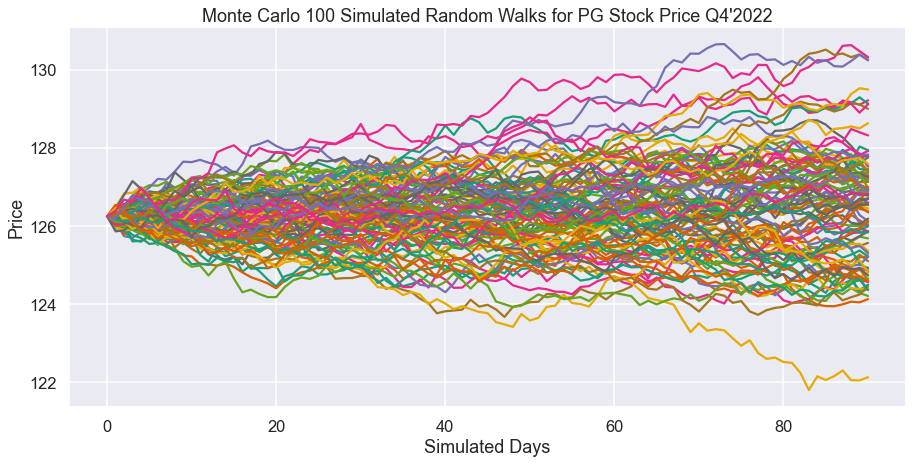

In [31]:
last_price = stocks['PG']['adjclose'][-1] 

plt.figure(figsize=(15,7))

for run in range(100):
    plt.plot(stock_monte_carlo(last_price,days,mu,sig))

plt.title("Monte Carlo 100 Simulated Random Walks for PG Stock Price Q4'2022")
plt.xlabel('Simulated Days')
plt.ylabel('Price')

### Set up number of runs and run simulation

In [32]:
runs = 20000

simulations = np.zeros(runs)

for run in range(runs):
    simulations[run] = stock_monte_carlo(last_price,days,mu,sig)[days-1]

### Plot distribution of simulated prices and extract VaR

Text(0, 0.5, 'Frequency')

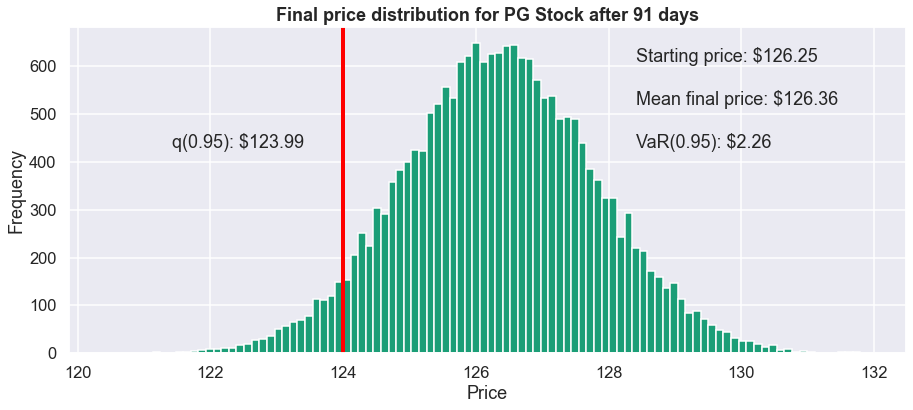

In [33]:
q = np.percentile(simulations,5)

plt.figure(figsize=(15,6))
plt.hist(simulations,bins=100)

plt.figtext(0.65,0.8,"Starting price: $%.2f" %last_price)

plt.figtext(0.65,0.7,"Mean final price: $%.2f" % simulations.mean())

plt.figtext(0.65,0.6,"VaR(0.95): $%.2f" % (last_price - q,))

plt.figtext(0.22,0.6, "q(0.95): $%.2f" % q)

plt.axvline(x=q, linewidth=4, color='r')

plt.title("Final price distribution for PG Stock after %s days" %days, weight='bold')
plt.xlabel('Price')
plt.ylabel('Frequency')